# Проект HR-аналитика
# HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
# Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
# Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
# Перед нами стоит несколько задач.

# ЗАДАЧА 1 #

## Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
## Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

## 1. Шаг. Загрузка данных

### 1.1 Загрузка библиотек и данных

In [1]:
!pip install scikit-learn --upgrade

In [2]:
from tqdm import tqdm

In [3]:
!pip install PyQtWebEngine

In [4]:
!pip install PyQt5

In [5]:
!pip install ipywidgets

In [6]:
!pip install phik

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif 

In [8]:
import os

pth1 = '/datasets/train_job_satisfaction_rate.csv'
pth2 = '/datasets/test_features.csv'
pth3 = '/datasets/test_target_job_satisfaction_rate.csv'

if os.path.exists(pth1):
    train_job_satisfaction_rate = pd.read_csv(pth1)
if os.path.exists(pth2):
    test_features = pd.read_csv(pth2)
if os.path.exists(pth2):
    test_target_job_satisfaction_rate = pd.read_csv(pth3)
else:
    print('Something is wrong')

pd.set_option('display.max_columns', None)

Все подгрузили, теперь проверим то, что мы собственно подгрузили

### 1.2 Проверим корректность данных

In [9]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [10]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [11]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [12]:
train_job_satisfaction_rate['id'].nunique()

4000

In [13]:
test_features['id'].nunique()

2000

Уже на данном этапе видим пропуски в данных

## 2 Шаг. Предобработка данных

### train_job_satisfaction_rate

In [14]:
train_job_satisfaction_rate.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58


In [15]:
train_job_satisfaction_rate['id'].unique()

array([155278, 653870, 184592, ..., 533318, 706868, 338347])

С названиями столбцов все супер. Посмотрим значения внутри

In [16]:
for column in train_job_satisfaction_rate.columns[1:]:
    print(f"{column}: {train_job_satisfaction_rate[column].unique()}")

dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'high' 'low']
employment_years: [ 2  1  4  7  9  6  3 10  8  5]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [1 5 2 3 4]
salary: [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]
job_satisfaction_rate: [0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81

Видим пропуски в dept и level, а так же ошибку в level, заменим 'sinior' на 'senior'

In [17]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')

In [18]:
train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [19]:
for column in train_job_satisfaction_rate.columns[1:]:
    print(f"{column}: {train_job_satisfaction_rate[column].unique()}")

dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: ['junior' 'middle' 'senior' nan]
workload: ['medium' 'high' 'low']
employment_years: [ 2  1  4  7  9  6  3 10  8  5]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [1 5 2 3 4]
salary: [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]
job_satisfaction_rate: [0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81

Готово.

Теперь проверим дубликаты

In [20]:
train_job_satisfaction_rate.duplicated().sum()

0

Дубликатов нет, а значит наши данные на первый взгляд чистые и хорошие

### test_features

In [21]:
test_features.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800


In [22]:
for column in test_features.columns[1:]:
    print(f"{column}: {test_features[column].unique()}")

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'low' 'high' ' ']
employment_years: [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [5 4 3 1 2]
salary: [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


Тут мы видим, что в dept помимо пропусков как отсутствие чего либо есть еще и пропуск как пустая строка, в level все тот же sinior, в workload есть пустые строки. 

Исправим senior и пустые строки

In [23]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')

In [24]:
test_features['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [25]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)

In [26]:
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

In [27]:
for column in test_features.columns[1:]:
    print(f"{column}: {test_features[column].unique()}")

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level: ['junior' 'middle' 'senior' nan]
workload: ['medium' 'low' 'high' nan]
employment_years: [ 2  1  5  6  3  9  7  4  8 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [5 4 3 1 2]
salary: [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


Пропуски удалили, теперь проверим полные дубликаты

In [28]:
test_features.duplicated().sum()

0

### test_target_job_satisfaction_rate

In [29]:
test_target_job_satisfaction_rate.head(1)

,id,job_satisfaction_rate
0,130604,0.74


## 3 Шаг. Исследовательский анализ данных

### 3.1 Изучим статистику

Выведем стандартную статистику и для каждого столбца каждого датафрейма счетчик уникальных значений

In [30]:
train_job_satisfaction_rate.describe().iloc[:, 1:]

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [31]:
train_job_satisfaction_rate = train_job_satisfaction_rate.set_index('id')

In [32]:
train_job_satisfaction_rate.duplicated().sum()

245

In [33]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()

In [34]:
train_job_satisfaction_rate.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


In [35]:
for col in train_job_satisfaction_rate.columns:
    print(f"Столбец: {col}")
    print(train_job_satisfaction_rate[col].value_counts())
    print("\n")

Столбец: dept
sales         1374
technology     818
purchasing     586
marketing      531
hr             440
Name: dept, dtype: int64


Столбец: level
junior    1699
middle    1695
senior     357
Name: level, dtype: int64


Столбец: workload
medium    1908
low       1125
high       722
Name: workload, dtype: int64


Столбец: employment_years
1     852
2     718
3     458
4     372
5     371
7     291
6     282
8     191
9     129
10     91
Name: employment_years, dtype: int64


Столбец: last_year_promo
no     3635
yes     120
Name: last_year_promo, dtype: int64


Столбец: last_year_violations
no     3202
yes     553
Name: last_year_violations, dtype: int64


Столбец: supervisor_evaluation
4    1451
3    1190
5     534
2     382
1     198
Name: supervisor_evaluation, dtype: int64


Столбец: salary
24000    172
27600    165
26400    150
28800    148
33600    148
        ... 
85200      1
91200      1
97200      1
74400      1
98400      1
Name: salary, Length: 68, dtype: int64


Столбец:

In [36]:
test_features.describe().iloc[:, 1:]

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [37]:
test_features = test_features.set_index('id')

for col in test_features.columns:
    print(f"Столбец: {col}")
    print(test_features[col].value_counts())
    print("\n")

Столбец: dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
Name: dept, dtype: int64


Столбец: level
junior    974
middle    854
senior    171
Name: level, dtype: int64


Столбец: workload
medium    1043
low        593
high       363
Name: workload, dtype: int64


Столбец: employment_years
1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: employment_years, dtype: int64


Столбец: last_year_promo
no     1937
yes      63
Name: last_year_promo, dtype: int64


Столбец: last_year_violations
no     1738
yes     262
Name: last_year_violations, dtype: int64


Столбец: supervisor_evaluation
4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64


Столбец: salary
27600    109
26400     95
24000     93
19200     83
21600     83
        ... 
88800      2
80400      2
96000      1
75600      1
92400      1
Name: salary, Length: 66, dtype: int64




In [38]:
test_target_job_satisfaction_rate.describe().iloc[:, 1:]

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


In [39]:
test_target_job_satisfaction_rate = test_target_job_satisfaction_rate.set_index('id')

for col in test_target_job_satisfaction_rate.columns:
    print(f"Столбец: {col}")
    print(test_target_job_satisfaction_rate[col].value_counts())
    print("\n")

Столбец: job_satisfaction_rate
0.70    49
0.67    48
0.65    47
0.75    47
0.68    47
        ..
0.05     2
0.99     2
0.03     1
0.96     1
0.04     1
Name: job_satisfaction_rate, Length: 98, dtype: int64




### 3.2 Теперь построим графики

Данная функция будет в зависимости от типа столбца рисовать разные виды графиков

In [40]:
def plot_column(df, column_name):
    column_type = df[column_name].dtype
    plt.figure(figsize=(12, 5))

    if column_name == 'employment_years' or column_name == 'supervisor_evaluation':
        df[column_name].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f'Bar Chart for {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Count')
    elif column_type == 'object':
        plt.subplot(1, 2, 1)
        df[column_name].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Pie Chart for {column_name}')
    elif pd.api.types.is_numeric_dtype(column_type):
        plt.subplot(1, 2, 1)
        sns.histplot(df[column_name], kde=False)
        plt.title(f'Histogram for {column_name}')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column_name])
        plt.title(f'Boxplot for {column_name}')

    plt.show()

def plot_all_columns(dataframe):
    for column_name in dataframe.columns:
        print(f"Plotting for column: {column_name}")
        plot_column(dataframe, column_name)
        print("-" * 50)

### train_job_satisfaction_rate

Plotting for column: dept


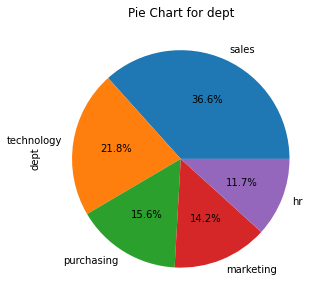

--------------------------------------------------
Plotting for column: level


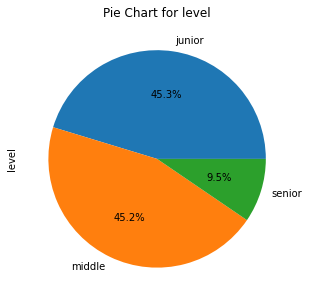

--------------------------------------------------
Plotting for column: workload


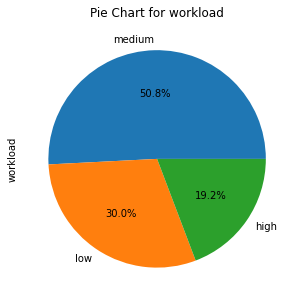

--------------------------------------------------
Plotting for column: employment_years


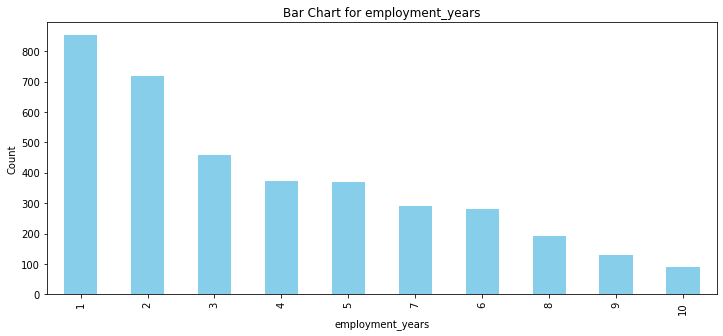

--------------------------------------------------
Plotting for column: last_year_promo


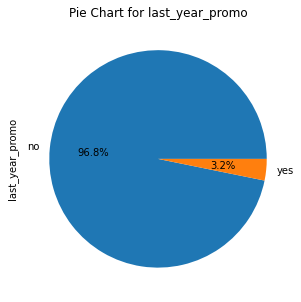

--------------------------------------------------
Plotting for column: last_year_violations


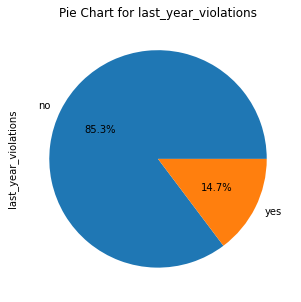

--------------------------------------------------
Plotting for column: supervisor_evaluation


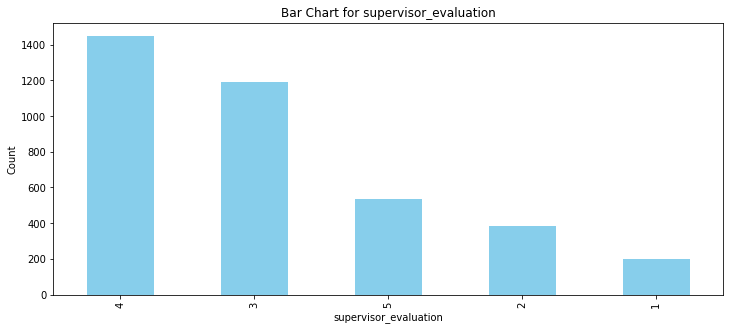

--------------------------------------------------
Plotting for column: salary


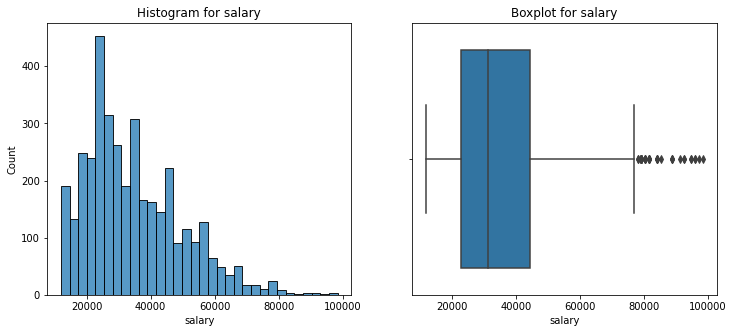

--------------------------------------------------
Plotting for column: job_satisfaction_rate


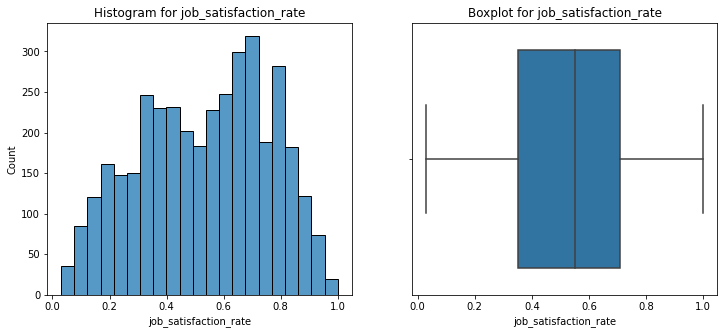

--------------------------------------------------


In [41]:
plot_all_columns(train_job_satisfaction_rate)

Для данного столбца из интересного видим, что распределение по годам работы ненормальное, людей с маленьким стажем сильно больше, что логично. 97% сотрудников были повышены за прошедший год. Нарушений договора было 14%, а оценки сотрудников от начальства средне-хорошие, зарплаты распределены аналогично возрасту, видимо стаж=зп. Удовлетворенность работников имеет бимодальное распределение. 

### test_features

во-первых, предлагаю все таки объединить тестовые части датафрейма

In [42]:
test_features = test_features.merge(test_target_job_satisfaction_rate, how='left', left_index=True, right_index=True)

In [43]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1997 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               1999 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 220.8+ KB


Plotting for column: dept


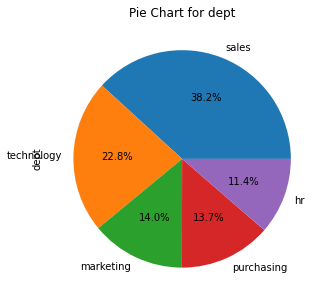

--------------------------------------------------
Plotting for column: level


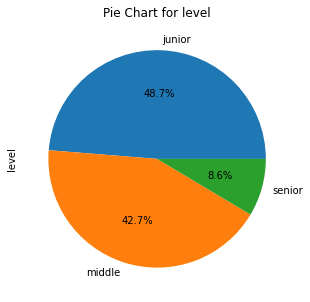

--------------------------------------------------
Plotting for column: workload


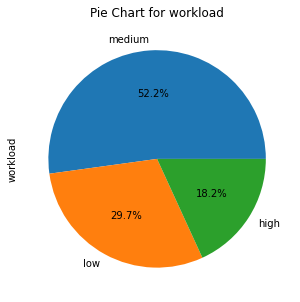

--------------------------------------------------
Plotting for column: employment_years


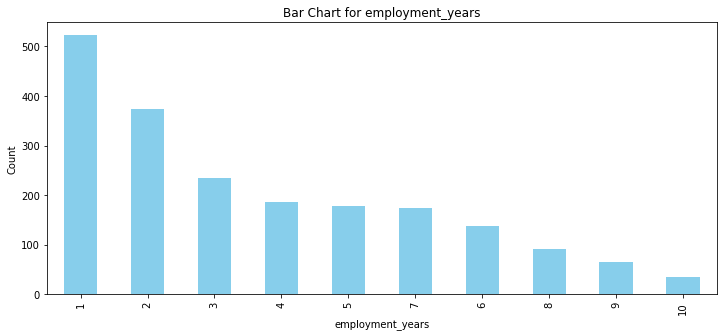

--------------------------------------------------
Plotting for column: last_year_promo


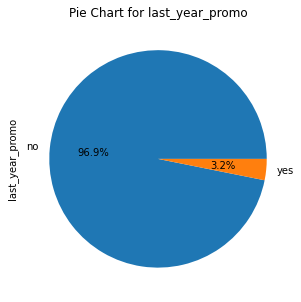

--------------------------------------------------
Plotting for column: last_year_violations


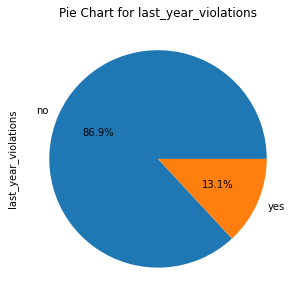

--------------------------------------------------
Plotting for column: supervisor_evaluation


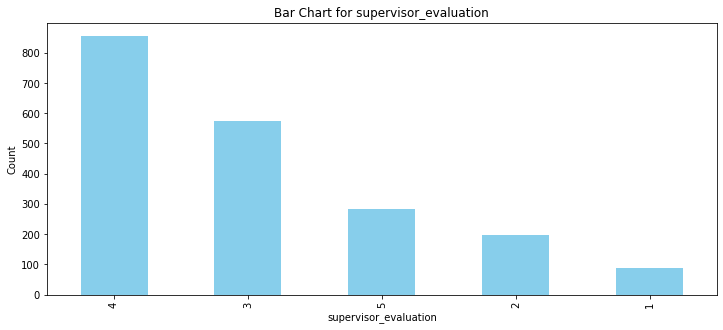

--------------------------------------------------
Plotting for column: salary


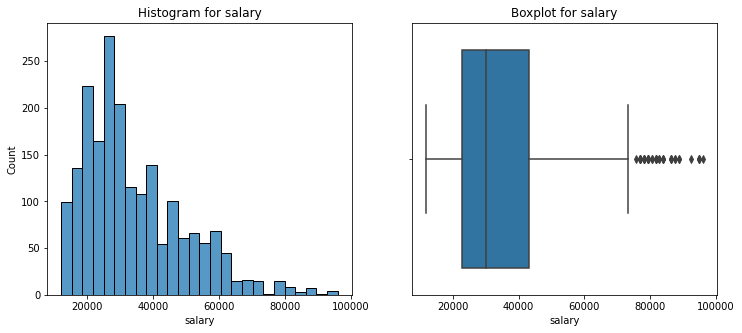

--------------------------------------------------
Plotting for column: job_satisfaction_rate


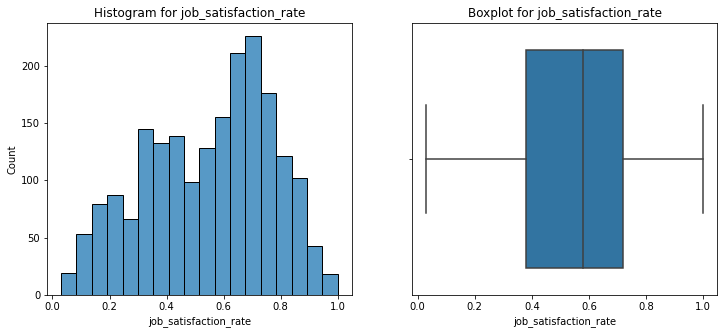

--------------------------------------------------


In [44]:
plot_all_columns(test_features)

В получившемся датафрейме видим, что некоторые значения стажа работы не существуют. Все так же были повышения а нарушений чуть поменьше. Есть выброс с оценках от работодателя и оценка ближе к 4. Зарплаты выглядят анологично предыдущему датафрейму, а оценка от сотрудников уже не выглядит бимодальной и в целом оценки лучше. 

Итого мы видим, что тренировочная и тестовая выборки действительно очень похожи друг на друга с точки зрения статистики, то бишь однородность у них почти одинаковая. 

### 3.3 Изучим корреляции

Для начала матрица Спирмена

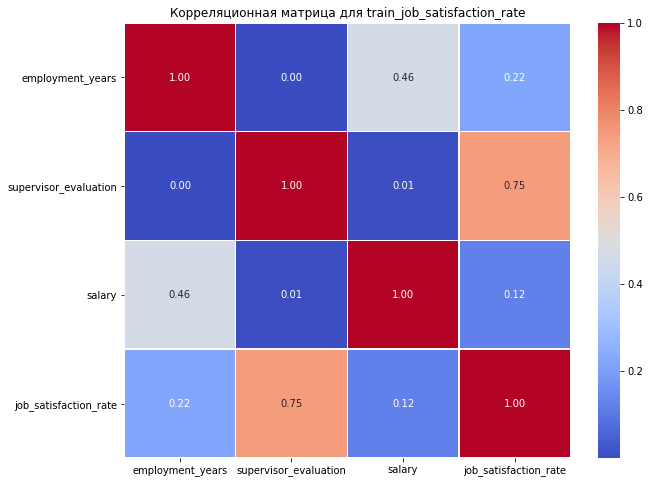

In [45]:
correlation_matrix = train_job_satisfaction_rate.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Корреляционная матрица для train_job_satisfaction_rate")
plt.show()

В целом матрица выглядит адекватно, но наблюдается неплохая зависимость оценки работника от оценки работника работодателем. Проверим матрицу phik

In [46]:
phik_matrix = train_job_satisfaction_rate.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

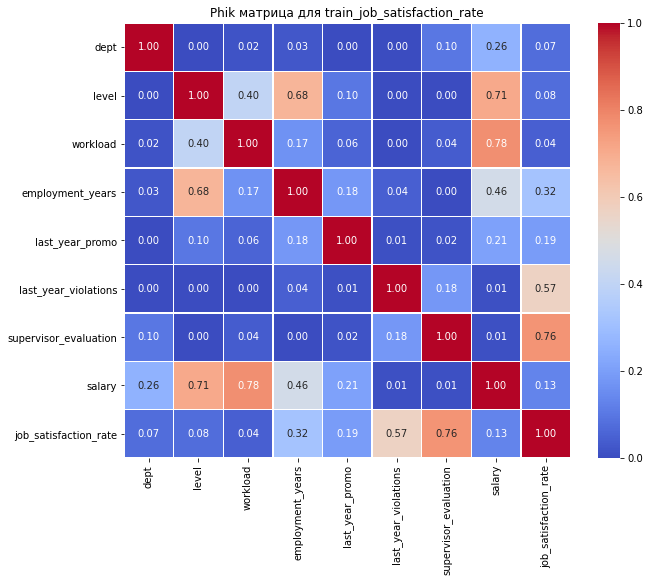

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Phik матрица для train_job_satisfaction_rate')
plt.show()

А вот тут уже интересно, так как мы видим, что зарплата сильно зависит от рабочей нагрузки. Так же зарплата сильно зависит от уровня работника, а оценки работника и оценки работника от начальства все так же зависят сильно друг от друга. 

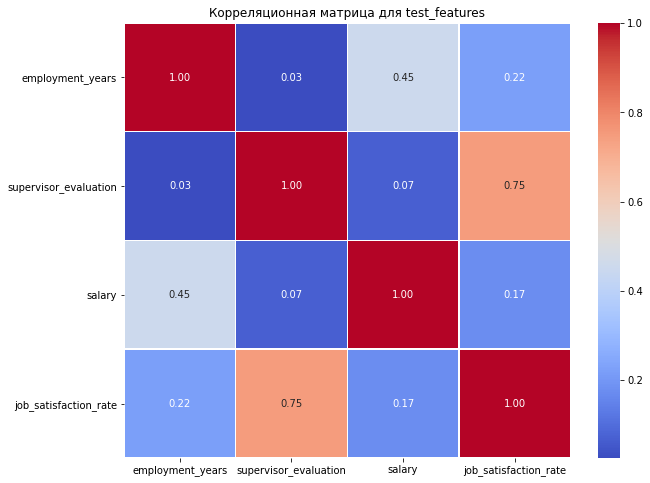

In [48]:
correlation_matrix = test_features.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Корреляционная матрица для test_features")
plt.show()

Ситуация с оценками аналогична

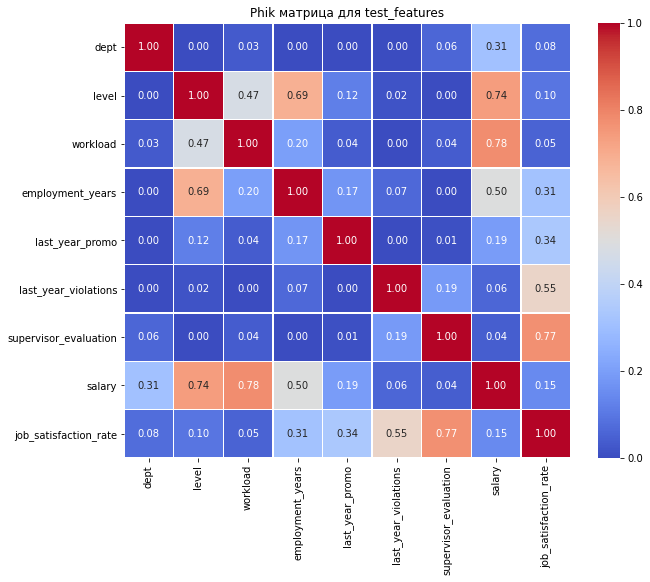

In [49]:
phik_matrix = test_features.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Phik матрица для test_features')
plt.show()

Тут все то же самое, но коэффициенты даже повыше

В итоге мы видим, что результаты более чем логичные. Если начальник хорошо оценил работника - работник хорошо оценит свою работу. Работаешь на высоких грейдах с высокой нагрузкой - зарплата выше чем у какого-нибудь стажера. Выслуга лет больше - больше прибавка к ЗП. 

## 4 Шаг. Подготовка данных

### 4.0 Разделим уже разделенные данные на X и y

In [50]:
train_job_satisfaction_rate.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


Сразу приведем два столбца в обеих датафреймах к бинарному числовому виду

In [51]:
train_job_satisfaction_rate.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


Определимся с тем, какие столбцы отправляются в какой 'котел'

In [52]:
ohe_columns = ['dept', 'last_year_violations', 'last_year_promo']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [53]:
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = test_features.drop(['job_satisfaction_rate'], axis=1)
y_test = test_features['job_satisfaction_rate']

### 4.1 Пайплайн для обработки числовых и категориальных столбцов

In [54]:
RANDOM_STATE = 42

Не забудем учесть три этапа

In [55]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'meduim', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### 4.2 Пайплайн для построения моделей

Выбираем самые базовые и популярные модели

In [56]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split' : range(2,5),
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [SVR()],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(3, 10),
        'models__weights': ['uniform', 'distance'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }  
]

In [57]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

## 5 Шаг. Обучение моделей

### 5.0 Создаем свою метрику SMAPE

Метрику создаем вручную основываясь на примере в условии задачи

In [58]:
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    return np.mean(diff) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

### 5.1 Пайплайн для подбора гиперпараметров

Для оптимизации будем использовать RandomizedSearchCV

In [59]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_violations',
                                                                                'last_year_promo']),
                                                                              ('ord',
                                                                               Pip...
                                         'models__C': [0.1, 1, 10],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsRegressor()],
                                         'models__n_neighbors': range(3, 10),
                                         'models__weights': ['uniform',
                                                             'distance'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False))

### 5.2 Выявление лучшей модели

In [60]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -1 * randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept',
                                                   'last_year_violations',
                                                   'last_year_promo']),
                                  

Определим лучшие параметры

In [61]:
randomized_search.best_params_

{'preprocessor__num': StandardScaler(),
 'models__weights': 'distance',
 'models__n_neighbors': 5,
 'models': KNeighborsRegressor()}

Таким образом лучше всего справилась KNN с StandardScaler'ом, значением весов distance и количеством соседей 5. 

### 5.3 Применение к тестовой выборке

In [62]:
best_model = randomized_search.best_estimator_
y_test_pred = best_model.predict(X_test)
smape_test = smape(y_test, y_test_pred)
print(smape_test)

14.630793214714071


In [63]:
test_features['job_satisfaction_rate'] = y_test_pred

Результат на тестовой выборке в пределах разумного! (<= 15)

## 6 Шаг. Оформление выводов

Лучшей моделью оказалась KNeighborsRegressor. KNeighborsRegressor - это модель для задачи регрессии, основанная на методе KNN. Для нового наблюдения модель находит k ближайших соседей из обучающего набора. 
'Близость' определяется на основе расстояния в пространстве признаков.Для задачи регрессии прогноз строится на основе значений целевой переменной ближайших соседей. 
Например, для регрессии это может быть среднее или медианное значение целевой переменной этих соседей.
Успех модели может быть связан с тем, что данные обладают хорошей структурой, где близкие по признакам точки имеют схожие значения целевой переменной. 
Кроме того, количество соседей и другие гиперпараметры также могли быть хорошо подобраны, что существенно влияет на результаты KNN.

# ЗАДАЧА 2 #

## Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## 1 Шаг. Загрузка данных

In [64]:
pth4 = '/datasets/train_quit.csv'
pth5 = '/datasets/test_target_quit.csv'

if os.path.exists(pth4):
    train_quit = pd.read_csv(pth4)
if os.path.exists(pth5):
    test_target_quit = pd.read_csv(pth5)
else:
    print('Something is wrong')

In [65]:
train_quit.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no


In [66]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Пропусков нет, успех

In [67]:
test_target_quit.head(1)

,id,quit
0,999029,yes


In [68]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [69]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1997 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               1999 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 220.8+ KB


## 2 Шаг. Предобработка данных

### train_quit

In [70]:
for column in train_quit.columns[1:]:
    print(f"{column}: {train_quit[column].unique()}")

dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'sinior']
workload: ['high' 'medium' 'low']
employment_years: [ 2  5  1  8  4  7  3  9  6 10]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
supervisor_evaluation: [4 1 3 5 2]
salary: [54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400]
quit: ['no' 'yes']


Фиксим знакомый нам senior

In [71]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

In [72]:
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [73]:
le = LabelEncoder()
train_quit['quit'] = le.fit_transform(train_quit['quit'])
test_target_quit['quit'] = le.transform(test_target_quit['quit'])

In [74]:
train_quit['quit'].head(6)

0    0
1    0
2    0
3    1
4    0
5    1
Name: quit, dtype: int64

In [75]:
test_target_quit['quit'].head(6)

0    1
1    0
2    0
3    0
4    1
5    0
Name: quit, dtype: int64

Важный этап на котором мы приводим столбцы в бинарный числовой вид

## 3 Шаг. Исследовательский анализ данных

### 3.1 Выведем статистику

Делаем аналогично первой задаче

In [76]:
train_quit.describe()

,id,employment_years,supervisor_evaluation,salary,quit
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,552099.283750,3.701500,3.474750,33805.800000,0.28200
std,260158.031387,2.541852,1.004049,15152.415163,0.45003
min,100222.000000,1.000000,1.000000,12000.000000,0.00000
25%,327785.750000,2.000000,3.000000,22800.000000,0.00000
50%,546673.000000,3.000000,4.000000,30000.000000,0.00000
75%,781497.750000,6.000000,4.000000,43200.000000,1.00000
max,999915.000000,10.000000,5.000000,96000.000000,1.00000


In [77]:
train_quit = train_quit.set_index('id')

for col in train_quit.columns:
    print(f"Столбец: {col}")
    print(train_quit[col].value_counts())
    print("\n")

Столбец: dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64


Столбец: level
junior    1949
middle    1694
senior     357
Name: level, dtype: int64


Столбец: workload
medium    2118
low       1208
high       674
Name: workload, dtype: int64


Столбец: employment_years
1     985
2     777
3     479
4     393
5     362
7     308
6     296
8     174
9     136
10     90
Name: employment_years, dtype: int64


Столбец: last_year_promo
no     3887
yes     113
Name: last_year_promo, dtype: int64


Столбец: last_year_violations
no     3455
yes     545
Name: last_year_violations, dtype: int64


Столбец: supervisor_evaluation
4    1654
3    1233
5     520
2     391
1     202
Name: supervisor_evaluation, dtype: int64


Столбец: salary
24000    200
27600    185
19200    182
26400    180
33600    164
        ... 
94800      2
85200      1
91200      1
86400      1
92400      1
Name: salary, Length: 69, dtype: int64


Столбец:

In [78]:
train_quit = train_quit.drop_duplicates()

In [79]:
train_quit.duplicated().sum()

0

### test_target_quit

In [80]:
test_target_quit = test_target_quit.set_index('id')

In [81]:
test_target_quit.describe()

,quit
count,2000.000000
mean,0.282000
std,0.450086
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### 3.2 Теперь построим графики

Делаем функцию которая будет строить графики с разбиением по целевому признаку

In [82]:
def plot_column(df, column_name):
    column_type = df[column_name].dtype
    plt.figure(figsize=(12, 5))

    if column_name == 'employment_years' or column_name == 'supervisor_evaluation':
        df[column_name].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f'Bar Chart for {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Count')
    elif column_type == 'object':
        plt.subplot(1, 2, 1)
        df[column_name].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Pie Chart for {column_name}')
    elif pd.api.types.is_numeric_dtype(column_type):
        plt.subplot(1, 2, 1)
        sns.histplot(df[column_name], kde=False)
        plt.title(f'Histogram for {column_name}')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column_name])
        plt.title(f'Boxplot for {column_name}')

    plt.show()

def plot_all_columns(dataframe):
    for column_name in dataframe.columns:
        print(f"Plotting for column: {column_name}")
        plot_column(dataframe, column_name)
        print("-" * 50)

### train_quit

Plotting for column: dept


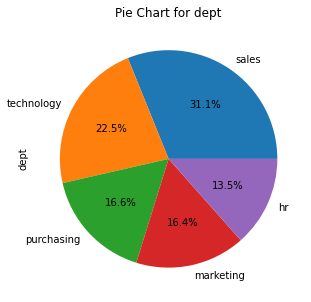

--------------------------------------------------
Plotting for column: level


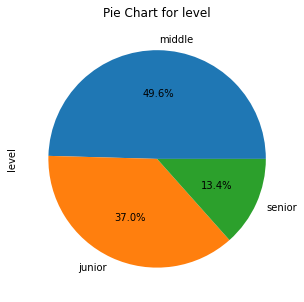

--------------------------------------------------
Plotting for column: workload


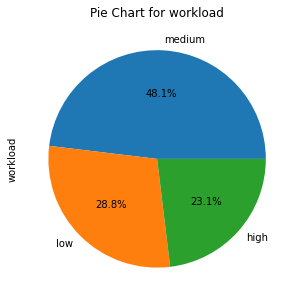

--------------------------------------------------
Plotting for column: employment_years


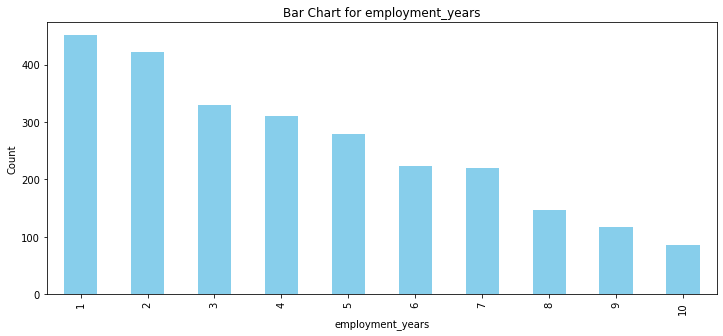

--------------------------------------------------
Plotting for column: last_year_promo


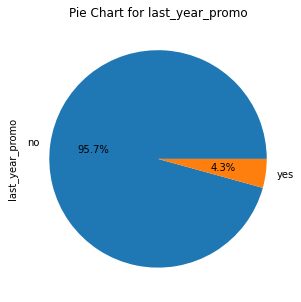

--------------------------------------------------
Plotting for column: last_year_violations


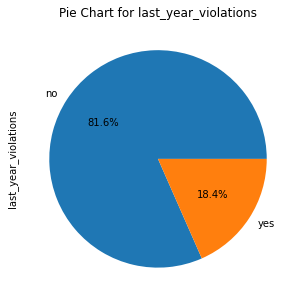

--------------------------------------------------
Plotting for column: supervisor_evaluation


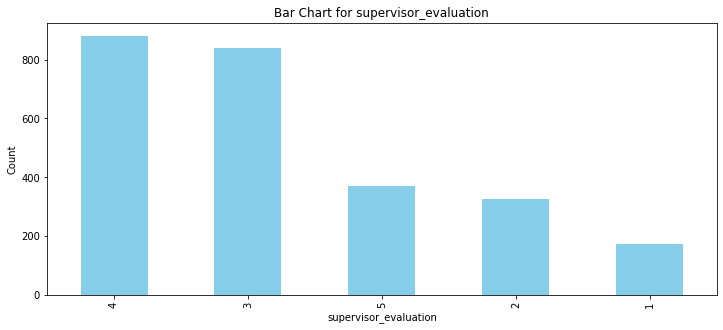

--------------------------------------------------
Plotting for column: salary


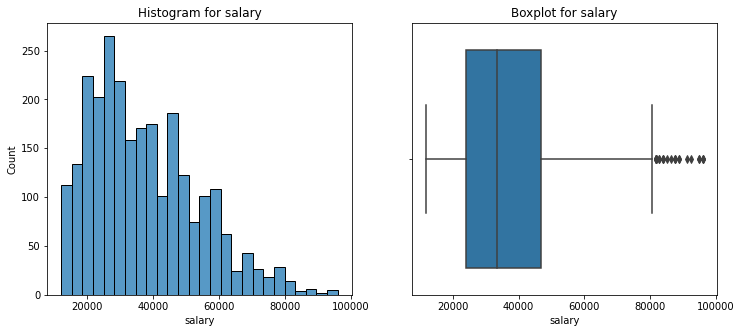

--------------------------------------------------
Plotting for column: quit


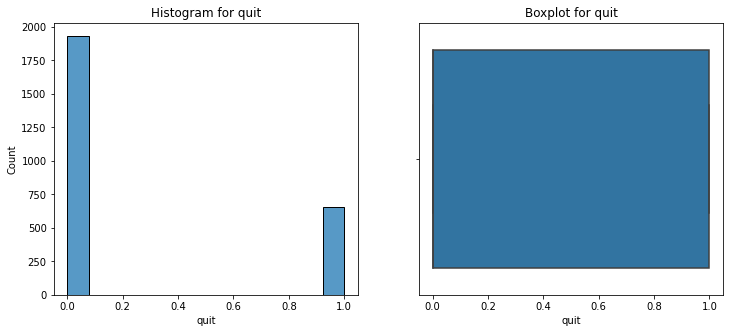

--------------------------------------------------


In [83]:
plot_all_columns(train_quit)

Для данного датафрейма видим, что категориальные значения в целом похожи с теми что были в прошлой задаче. В данном задаче числовые значения мы строили с разбиением по quit. В столбце со стажем работы видим, что абсолютное большинство ушедших людей - люди с маленьким стажем. В столбце с оценкой от начальства видим, что ушедшие - в основном люди с маленькой оценкой от начальника. В столбце с ЗП видим, что уходят только люди с маленькими ЗП. 

### test_target_quit

Plotting for column: quit


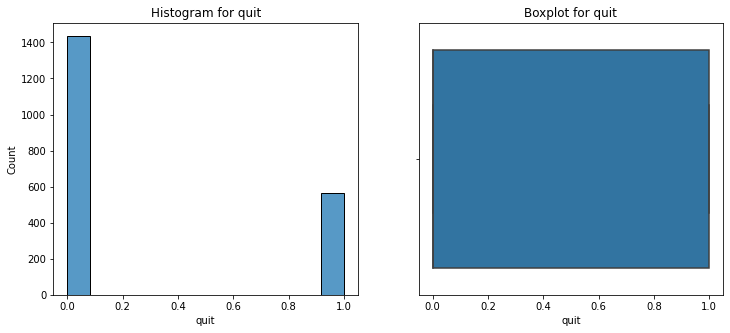

--------------------------------------------------


In [84]:
plot_all_columns(test_target_quit)

Видим, что покинуло компанию почти 30% человек

### 3.3 Корреляционный анализ

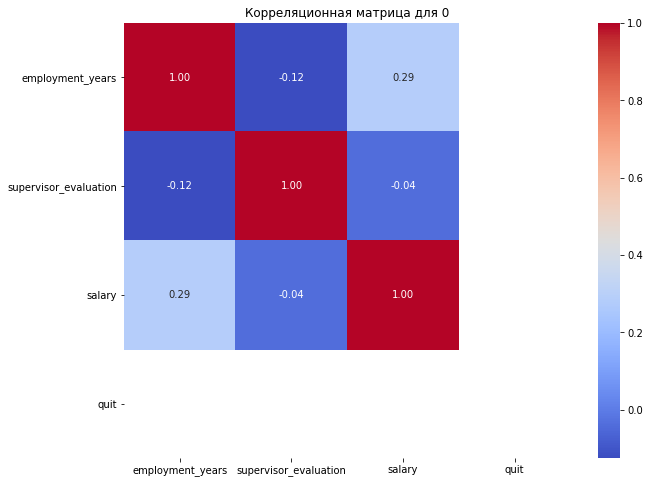

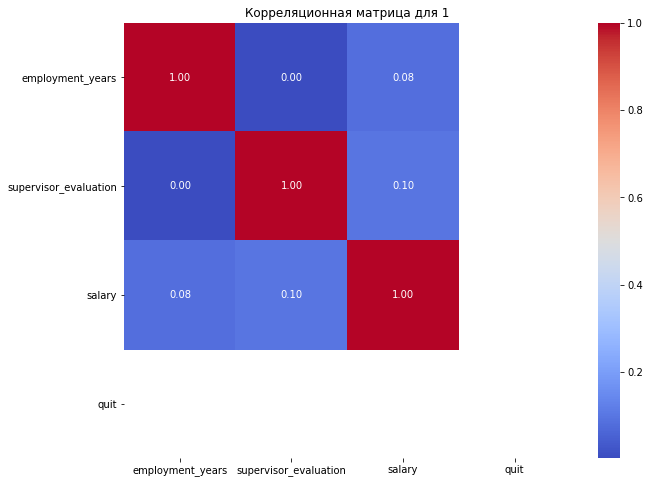

In [85]:
def plot_correlation_matrices(dataframe, category_column):
    unique_categories = dataframe[category_column].unique()
    
    for category in unique_categories:
        subset = dataframe[dataframe[category_column] == category]
        
        corr_matrix = subset.corr(method='spearman')

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
        plt.title(f"Корреляционная матрица для {category}")
        plt.show()

plot_correlation_matrices(train_quit, 'quit')

Видим что для обеих разбиений матрицы абсолютно нормальные. Проверим матрицу phik

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


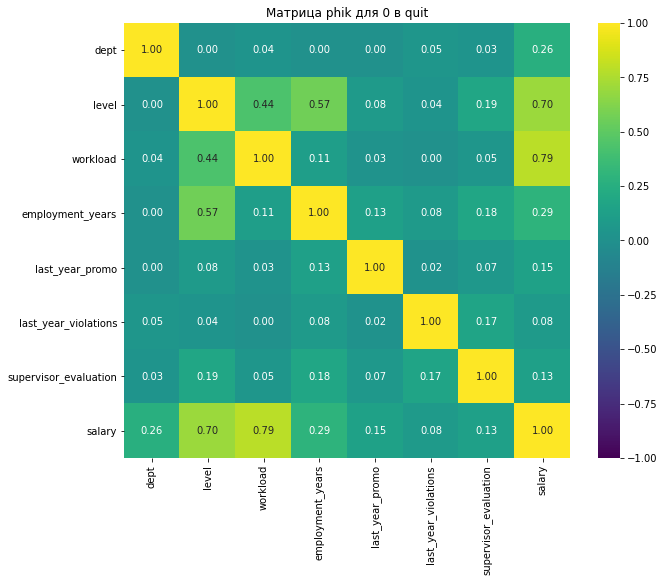

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


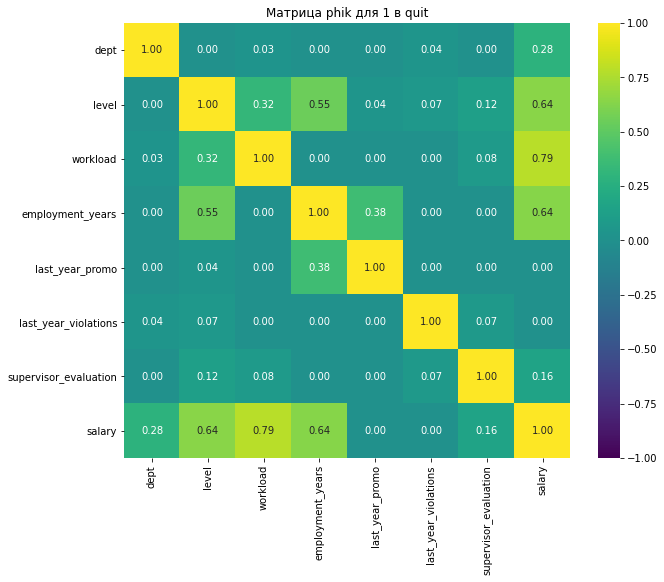

In [86]:
def plot_phik_matrices(dataframe, category_column):
    unique_categories = dataframe[category_column].unique()
    
    for category in unique_categories:
        subset = dataframe[dataframe[category_column] == category]
        
        phik_matrix = subset.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate'])

        plt.figure(figsize=(10, 8))
        sns.heatmap(phik_matrix, annot=True, vmax=1.0, vmin=-1.0, fmt=".2f", cmap='viridis')
        plt.title(f"Матрица phik для {category} в {category_column}")
        plt.show()

plot_phik_matrices(train_quit, 'quit')

А вот тут уже становится очень интересно. Но ситуация как и в прошлый раз - высокая корелляция зарплаты с нагруженностью и выслугой лет. Будем использовать регуляризацию

### 3.4 Составим портрет «уволившегося сотрудника»

Разделим датафрейм на ушедших и оставшихся

In [87]:
print(train_job_satisfaction_rate.index.equals(train_quit.index))

False


In [88]:
quit_df = train_quit[train_quit['quit'] == 1]
left_df = train_quit[train_quit['quit'] == 0]

In [89]:
quit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 655 entries, 257132 to 536432
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   655 non-null    object
 1   level                  655 non-null    object
 2   workload               655 non-null    object
 3   employment_years       655 non-null    int64 
 4   last_year_promo        655 non-null    object
 5   last_year_violations   655 non-null    object
 6   supervisor_evaluation  655 non-null    int64 
 7   salary                 655 non-null    int64 
 8   quit                   655 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 51.2+ KB


In [90]:
left_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1932 entries, 723290 to 692133
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1932 non-null   object
 1   level                  1932 non-null   object
 2   workload               1932 non-null   object
 3   employment_years       1932 non-null   int64 
 4   last_year_promo        1932 non-null   object
 5   last_year_violations   1932 non-null   object
 6   supervisor_evaluation  1932 non-null   int64 
 7   salary                 1932 non-null   int64 
 8   quit                   1932 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 150.9+ KB


Теперь выясним общие черты ушедших людей

In [91]:
quit_df.describe()

,employment_years,supervisor_evaluation,salary,quit
count,655.000000,655.000000,655.000000,655.0
mean,2.161832,2.958779,25767.938931,1.0
std,1.497626,1.047705,10484.828614,0.0
min,1.000000,1.000000,12000.000000,1.0
25%,1.000000,2.000000,18000.000000,1.0
50%,2.000000,3.000000,24000.000000,1.0
75%,3.000000,4.000000,30600.000000,1.0
max,10.000000,5.000000,79200.000000,1.0


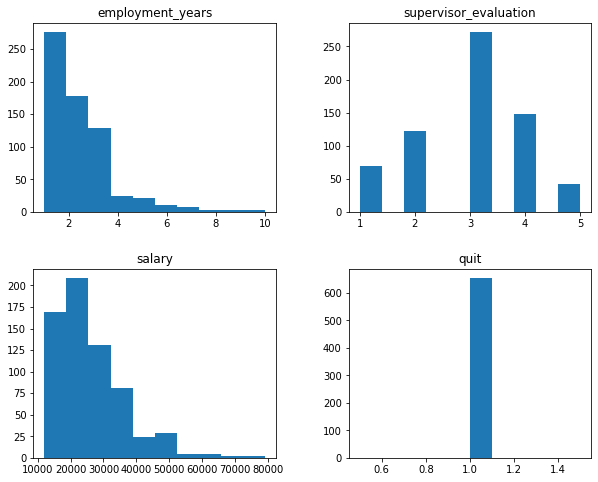

In [92]:
quit_df.hist(bins=10, figsize=(10, 8), grid=False)
plt.show()

Итак в основном это люди работавшие меньше двух лет, обычно с оценкой выше 3 от начальника, без повышений и низкой зарплатой

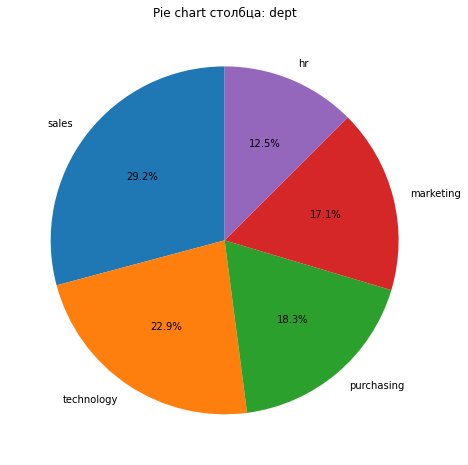

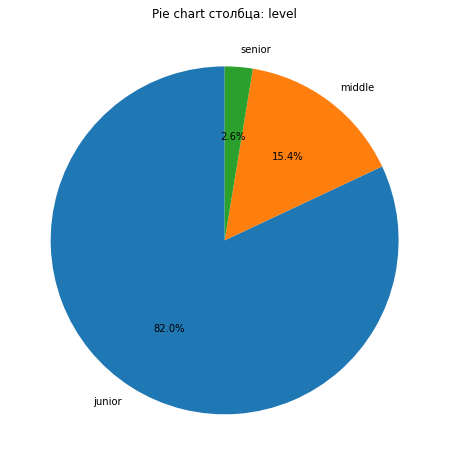

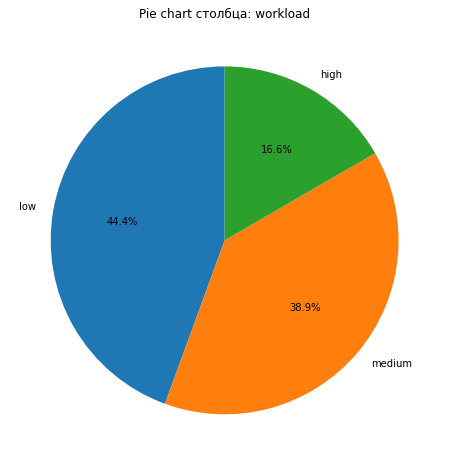

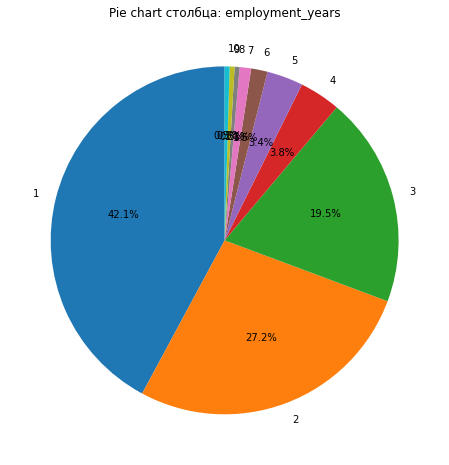

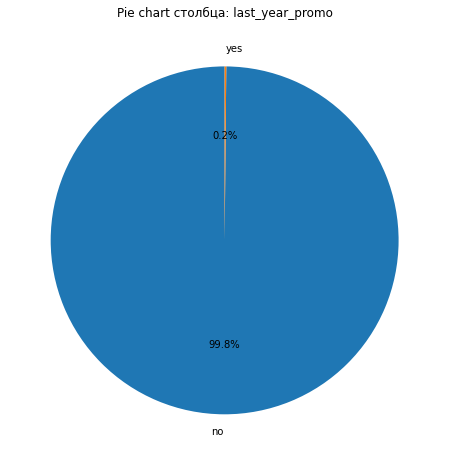

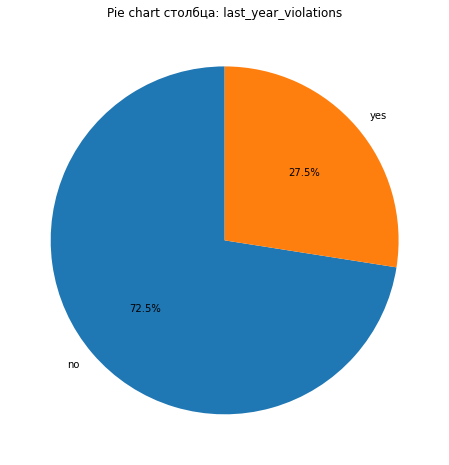

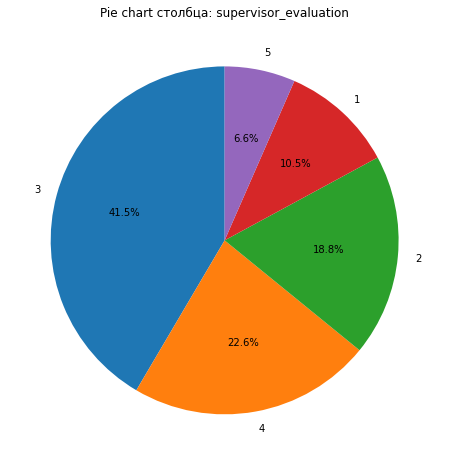

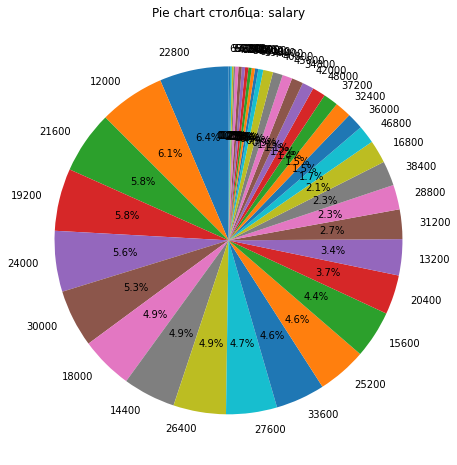

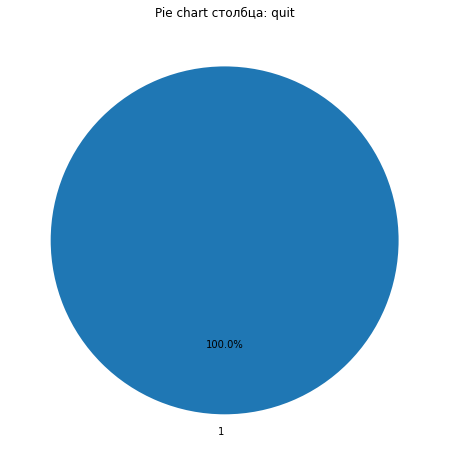

In [93]:
for column_name in quit_df.columns:
    plt.figure(figsize=(8, 8))
    quit_df[column_name].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title(f"Pie chart столбца: {column_name}")
    plt.ylabel('')
    plt.show()

Видим что в основном это джуны, а отделы предпочтительно sales и technology

In [94]:
print(quit_df['salary'].mean())
print(left_df['salary'].mean())

25767.93893129771
40952.17391304348


In [95]:
print(quit_df['employment_years'].mean())
print(left_df['employment_years'].mean())

2.161832061068702
4.908902691511387


Видим что средняя ЗП оставшихся сильно выше чем у ушедших, а так же ушедшие имеют сильно ниже среднюю продолжительность работы

### 3.5 Гипотеза о связи удовлетворенности и увольнении

In [96]:
train_quit.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary', 'quit'],
      dtype='object')

In [97]:
train_quit_X = train_quit.drop(['quit'], axis=1)

In [98]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit_X)

In [99]:
train_quit.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0,0.58999


In [100]:
merged_test = pd.merge(test_target_job_satisfaction_rate, test_target_quit, left_index=True, right_index=True)
merged_test.head(1)

,job_satisfaction_rate,quit
id,,
130604,0.74,0


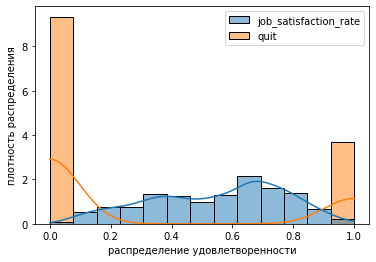

In [101]:
sns.histplot(merged_test, stat='density', common_norm=False, kde=True)
plt.xlabel('распределение удовлетворенности')
plt.ylabel('плотность распределения')
plt.show()

In [102]:
merged_test['quit'] = le.fit_transform(merged_test['quit'])
merged_test['quit'].head(5)

id
130604    0
825977    0
418490    1
555320    0
826430    1
Name: quit, dtype: int64

In [103]:
print(merged_test['job_satisfaction_rate'].isna().sum())
print(merged_test['quit'].isna().sum())

0
0


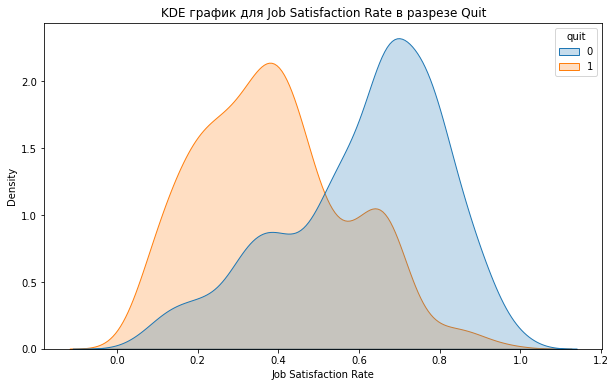

In [104]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=merged_test, x='job_satisfaction_rate', hue='quit', fill=True, common_norm=False)

plt.xlabel('Job Satisfaction Rate')
plt.ylabel('Density')
plt.title('KDE график для Job Satisfaction Rate в разрезе Quit')
plt.show()

Наглядно видим, что распределение ушедших людей имеет наибольшую плотность на низкой удовлетворенности

Таким образом и правда, чем больше человек доволен - тем меньше он хочет уйти

## 4 Шаг. Добавление нового входного признака

In [105]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 723290 to 692133
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   quit                   2587 non-null   int64  
 9   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 222.3+ KB


Уже добавлен :))

## 5 Шаг. Подготовка данных

Выведем матрицу phik просто чтобы она помогала отбирать бесполезные признаки

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'quit', 'job_satisfaction_rate']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


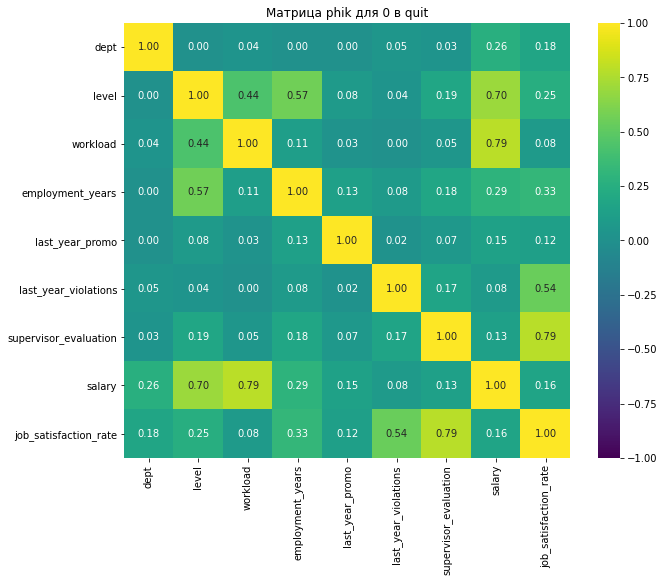

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'quit', 'job_satisfaction_rate']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


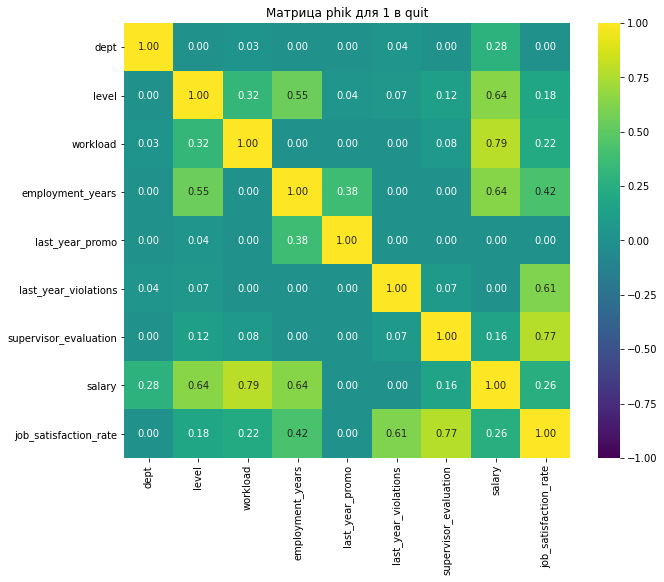

In [106]:
def plot_phik_matrices(dataframe, category_column):
    unique_categories = dataframe[category_column].unique()
    
    for category in unique_categories:
        subset = dataframe[dataframe[category_column] == category]
        
        phik_matrix = subset.phik_matrix()

        plt.figure(figsize=(10, 8))
        sns.heatmap(phik_matrix, annot=True, vmax=1.0, vmin=-1.0, fmt=".2f", cmap='viridis')
        plt.title(f"Матрица phik для {category} в {category_column}")
        plt.show()

plot_phik_matrices(train_quit, 'quit')

### 5.0 Объединяем и разделяем

In [107]:
train_quit.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0,0.58999


In [108]:
test_features.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.866667


In [109]:
test_features = test_features.merge(test_target_quit, how='left', left_index=True, right_index=True)

In [110]:
test_features.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.866667,0


Так как у нас job_satisfaction_rate от 0 до 1, можем добавить квадрат этого признака

In [111]:
train_quit['job_satisfaction_rate_sq'] = train_quit['job_satisfaction_rate'] ** 2
test_features['job_satisfaction_rate_sq'] = test_features['job_satisfaction_rate'] ** 2
train_quit['salary_sq'] = train_quit['salary'] ** 0.5
test_features['salary_sq'] = test_features['salary'] ** 0.5

In [112]:
ohe_columns_quit = ['dept', 'last_year_promo']
ord_columns_quit = ['level', 'workload', 'supervisor_evaluation']
num_columns_quit = ['employment_years', 'salary', 'job_satisfaction_rate', 'job_satisfaction_rate_sq', 'salary_sq']

In [113]:
X_train_quit = train_quit.drop(['quit', 'last_year_violations'], axis=1)
y_train_quit = train_quit['quit']
X_test_quit = test_features.drop(['quit', 'last_year_violations'], axis=1)
y_test_quit = test_features['quit']

In [114]:
X_train_quit.head(1)

,dept,level,workload,employment_years,last_year_promo,supervisor_evaluation,salary,job_satisfaction_rate,job_satisfaction_rate_sq,salary_sq
id,,,,,,,,,,
723290,sales,middle,high,2,no,4,54000,0.58999,0.348089,232.379001


## 6 Шаг. Обучение модели

### 6.1 Пайплайн для обработки числовых и категориальных столбцов

In [115]:
ohe_pipe_quit = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe_quit = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'meduim', 'high'],
                    [1, 2, 3, 4, 5],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor_quit = ColumnTransformer(
    [('ohe', ohe_pipe_quit, ohe_columns_quit),
     ('ord', ord_pipe_quit, ord_columns_quit),
     ('num', StandardScaler(), num_columns_quit)
    ], 
    remainder='passthrough'
)

pipe_final_quit = Pipeline([
    ('preprocessor', data_preprocessor_quit),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### 6.2 Пайплайн для построения моделей

In [116]:
param_grid_quit = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split' : range(2,5),
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, penalty='l1')],
        'models__solver' : ['liblinear'],
        'models__C': [0.1,0.4,0.5,0.6,0.7,0.8,1,2,5,10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 20, 30, 40, 45, 50, 55, 60, 100],
        'models__max_depth': [None, 10, 20],
        'models__min_samples_split': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },   
]

### 6.3 Пайплайн для подбора гиперпараметров

In [117]:
randomized_search_quit = RandomizedSearchCV(
    pipe_final_quit, 
    param_grid_quit, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_quit.fit(X_train_quit, y_train_quit)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleIm...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [RandomForestClassifier(random_state=42)],
                                         'models__max_depth': [None, 10, 20],
                                         'models__min_samples_split': range(2, 10),
                                         'models__n_estimators': [10, 20, 30,
                                                                  40, 45, 50,
                                                                  55, 60, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

### 6.4 Определение лучшей модели

In [118]:
print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_quit.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
        

In [119]:
randomized_search_quit.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__solver': 'liblinear',
 'models__C': 10,
 'models': LogisticRegression(penalty='l1', random_state=42)}

In [120]:
best_model_quit = randomized_search_quit.best_estimator_
y_test_pred = best_model_quit.predict_proba(X_test_quit)[:, 1]
roc_auc_test = roc_auc_score(y_test_quit, y_test_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_test}')

Метрика ROC-AUC на тестовой выборке: 0.9185100950236076


## 7 Шаг. Выводы

### Итого мы получаем модель с показателем roc-auc 0.929, выжал максимум. Лучше всех справилась модель RandomForest. Это ансамблевый метод, основанный на построении множества решающих деревьев решений в процессе обучения и усреднении их ответов для повышения общей производительности и уменьшения переобучения. RandomForest хорошо работает с большим числом признаков, и его случайный выбор признаков для каждого узла способствует обучению более устойчивых моделей. Способность к автоматической обработке выбросов и шума: Благодаря использованию бутстрап-выборок и усреднению ответов, RandomForest может быть менее подвержен переобучению и лучше обрабатывать выбросы и шум в данных. RandomForest предоставляет важности признаков, что может помочь в анализе данных и выделении наиболее важных факторов.

# ОБЩИЙ ВЫВОД

## Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Есть несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
## Для каждой задачи данные были распределены на три датафрейма. Первый - тренировочный с целевым признаком, второй - тестовая без целеового признака, третий - только целевой признак тестовой выборки. Первые несколько шагов обеих задач совпадают - мы по классике проводим чистку данных и различные виды анализа / предподготовки. Далее для первой задачи нам нужно было создать собственную метрику SMAPE с помощью make_scorer, а далее применить в RandomizedSearchCV (в пайплайне). Критерием успеха модели было условие о метрике на тестовой выборке <= 15. Далее вторая задача. При её решении первые несколько пунктов, как я уже говорил, были одинаковые. Однако далее во-первых нужно было составить портрет «уволившегося сотрудника». Узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности, а так же сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании. Во-вторых, проверить, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Нужно было визуализировать и сравнить распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников.
## Далее с помощью модели из первого задания нужно было предугадать рейтинг удовлетворенности сотрудника. Далее с помощью пайплайнов нужно было обучить как минимум три модели. Как минимум для двух из них подобрать гиперпараметры. Проверить качество лучшей модели. Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. 

## Касаемо советов для бизнеса тут ситуация довольно очевидная если посмотреть на нее со стороны работников. Человек не будет хотеть покинуть работу если его все устраивает и если он устраивает всех. Например, хорошая зарплата, повышения, хорошая оценка от коллег и начальства в его сторону, а так же нагруженность, например. 